In [1]:
import numpy as np
from glob import glob
from treem import Morph, Node, SWC
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
def load_branch(morph, stem):
    origin = Morph(data=np.array([[1, 1, 0, 0, 0, 5, -1],]))
    branch = morph.copy(stem)
    origin.graft(branch)
    for node in origin.stems():
        break
    shift = stem.coord() - origin.root.coord()
    origin.translate(-shift, node)
    return origin

In [3]:
mbranches = list()
for src in glob('../data/mouse/derived/sanitized/*.swc'):
    m = Morph(src)
    for stem in m.stems():
        if stem.type() == SWC.DEND:
            branch = load_branch(m, stem)
            breadth = stem.breadth()
            totlen = sum([x.length() for x in stem.walk()])
            mbranches.append([src, stem.ident(), branch, breadth, totlen])

In [4]:
mbranches = np.array(sorted(mbranches, key=lambda x: (x[3], x[4])))
f'{len(mbranches)=}, number of terminals {min(mbranches[:,3])}-{max(mbranches[:,3])}, mean {mbranches[:,3].mean()}'

'len(mbranches)=47, number of terminals 1-13, mean 4.382978723404255'

In [5]:
hbranches = list()
for src in glob('../data/human/derived/sanitized/*.swc'):
    m = Morph(src)
    for stem in m.stems():
        if stem.type() == SWC.DEND:
            branch = load_branch(m, stem)
            breadth = stem.breadth()
            totlen = sum([x.length() for x in stem.walk()])
            hbranches.append([src, stem.ident(), branch, breadth, totlen])

In [6]:
hbranches = np.array(sorted(hbranches, key=lambda x: (x[3], x[4])))
f'{len(hbranches)=}, number of terminals: {min(hbranches[:,3])}-{max(hbranches[:,3])}, mean {hbranches[:,3].mean()}'

'len(hbranches)=35, number of terminals: 1-21, mean 4.628571428571429'

In [7]:
def get_segdata(morph):
    m = morph
    d = dict()
    for i, t, x, y, z, r, p in m.data:
        i, t, x, y, z, r, p = int(i), int(t), x, y, z, r, int(p)
        d[i] = {'t': t, 'x': x, 'y': y, 'z': z, 'r': r, 'p': p}
    
    center = m.root.coord()
    for node in m.root.walk():
        if node.type() == SWC.SOMA:
            ident = node.ident()
            d[ident]['length'] = 0.0
            d[ident]['path'] = 0.0
            d[ident]['xsec'] = 0.0
            d[ident]['xsec_rel'] = 0.0
            d[ident]['dist'] = 0.0
            d[ident]['order'] = 0
            d[ident]['breadth'] = 0
            d[ident]['totlen'] = 0.0

    for stem in m.stems():
        for sec in stem.sections():
            order = 1
            xsec = 0.0
            seclen = m.length(sec)
            for node in sec:
                ident = node.ident()
                length = node.length()
                xsec += length
                if node.parent.is_fork() and node.parent != m.root:
                    order += 1
                dist = np.linalg.norm(center - node.coord())
                path = d[node.parent.ident()]['path']
                path += length
                d[ident]['length'] = length
                d[ident]['path'] = path
                d[ident]['xsec'] = xsec
                d[ident]['xsec_rel'] = xsec / seclen
                d[ident]['dist'] = dist
                d[ident]['order'] = order
                d[ident]['breadth'] = 1
                d[ident]['totlen'] = 0.0

    for term in m.root.leaves():
        for node in term.walk(reverse=True):
            if not node.is_leaf():
                ident = node.ident()
                descent_ident = [x.ident() for x in node.siblings]
                descent_length = [x.length() for x in node.siblings]
                descent_breadth = [d[i]['breadth'] for i in descent_ident]
                descent_totlen = [d[i]['totlen'] for i in descent_ident]
                breadth = sum(descent_breadth)
                totlen = sum(descent_totlen) + sum(descent_length)
                d[ident]['breadth'] = breadth
                d[ident]['totlen'] = totlen
                
    return np.array([[i, d[i]['t'], d[i]['x'], d[i]['y'], d[i]['z'], d[i]['r'], d[i]['p'], 
                      d[i]['length'], d[i]['path'], d[i]['xsec'], d[i]['xsec_rel'], 
                      d[i]['dist'], d[i]['order'], d[i]['breadth'], d[i]['totlen']] 
                     for i in sorted(d)])

In [8]:
I, T, X, Y, Z, R, P, LENGTH, PATH, XSEC, XSEC_REL, DIST, ORDER, BREADTH, TOTLEN = range(15)

In [9]:
class DGram():
    """Neuron dendrogram representation."""
    graph = None
    xdata = None
    types = None
    
    def __init__(self, morph=None, types=SWC.TYPES, spread=1.0):
        if morph:
            graph = morph.copy()
            for stem in graph.stems():
                if stem.type() not in types:
                    graph.prune(stem)
            graph = Morph(data=graph.data)
            self.graph = graph
            self.xdata = get_segdata(graph)
            self.types = types
            for sec in self.graph.root.sections():
                start_node = sec[0]
                seclink = start_node.length()
                secrad = self.graph.radii(sec).mean()
                for node in sec:
                    ident = node.ident()
                    data = self.graph.data[ident-1]
                    xdata = self.xdata[ident-1]
                    data[X] = xdata[PATH]
                    data[R] = secrad
            self.graph.data[:, SWC.YZ] = 0.0
            for stem in self.graph.stems():
                for sec in stem.sections():
                    start_node = sec[0]
                    parent = start_node.parent
                    shift = start_node.coord() - parent.coord()
                    self.graph.translate(-shift, start_node)
            for index,term in enumerate(self.graph.root.leaves(), start=1):
                pos = index*spread
                for node in term.walk(reverse=True):
                    ident = node.ident()
                    value = self.graph.data[ident-1]
                    if node.is_fork() or node.is_root():
                        pos = np.mean([x.coord()[1] for x in node.siblings])
                    value[SWC.Y] = pos

In [10]:
np.median(mbranches[:,3]), np.median(hbranches[:,3])

(4.0, 4.0)

In [11]:
mbreadth = np.mean(mbranches[:,3])  #np.median(mbranches[:,3])
hbreadth = np.mean(hbranches[:,3])  #np.median(hbranches[:,3])
breadth = max(np.median(mbranches[:,3]), np.median(hbranches[:,3]))  #np.rint(max(mbreadth, hbreadth))
(mbreadth, hbreadth, breadth)

(4.382978723404255, 4.628571428571429, 4.0)

In [12]:
mterms = set(mbranches[:,3])
mterms

{1, 2, 3, 4, 5, 6, 7, 8, 9, 13}

In [13]:
hterms = set(hbranches[:,3])
hterms

{1, 2, 3, 4, 5, 6, 7, 8, 15, 21}

In [14]:
msel = mbranches[:, 3] == breadth
hsel = hbranches[:, 3] == breadth
mavg = mbranches[msel][-1]
#havg = hbranches[hsel][-1]
havg = hbranches[hsel][-5]

In [15]:
mg = DGram(mavg[2], types=[SWC.DEND])

In [16]:
hg = DGram(havg[2], types=[SWC.DEND])

In [17]:
Set1 = mpl.colormaps.get_cmap('Set1')
Pastel1 = mpl.colormaps.get_cmap('Pastel1')
mcolor = Set1(0.0)
hcolor = Set1(1.0/9)
mcolor_light = Pastel1(0.0)
hcolor_light = Pastel1(1.0/9)

In [18]:
def plot_dgram(dgram, ax=None, color='black', plot_soma=True):
    if not ax:
        fig, ax = plt.subplots()
    
    root = dgram.graph.root
    if plot_soma:
        x = [-root.diam(), 0]
        y = [root.coord()[1]]*2
        ax.plot(x, y, color=color)

    for sec in root.sections():
        x = [sec[0].coord()[0], sec[-1].coord()[0]]
        y = [sec[0].coord()[1], sec[-1].coord()[1]]
        ax.plot(x, y, color=color)

    for stem in dgram.graph.stems():
        x = [root.coord()[0], stem.coord()[0]]
        y = [root.coord()[1], stem.coord()[1]]
        ax.plot(x, y, color=color)
    
    for bif in dgram.graph.root.forks():
        x = [bif.coord()[0], bif.siblings[0].coord()[0]]
        y = [bif.coord()[1], bif.siblings[0].coord()[1]]
        ax.plot(x, y, color=color)
        x = [bif.coord()[0], bif.siblings[1].coord()[0]]
        y = [bif.coord()[1], bif.siblings[1].coord()[1]]
        ax.plot(x, y, color=color)

    return ax

(array(['../data/mouse/derived/sanitized/animal_5_n21_04102017_cel1-cor-san.swc',
        301, <treem.morph.Morph object at 0x7f5a89455330>, 4,
        538.5186907154409], dtype=object),
 array(['../data/human/derived/sanitized/AB5_porta80A_cel17-cor-san.swc',
        14, <treem.morph.Morph object at 0x7f5a882e13c0>, 4,
        675.5537439796045], dtype=object))

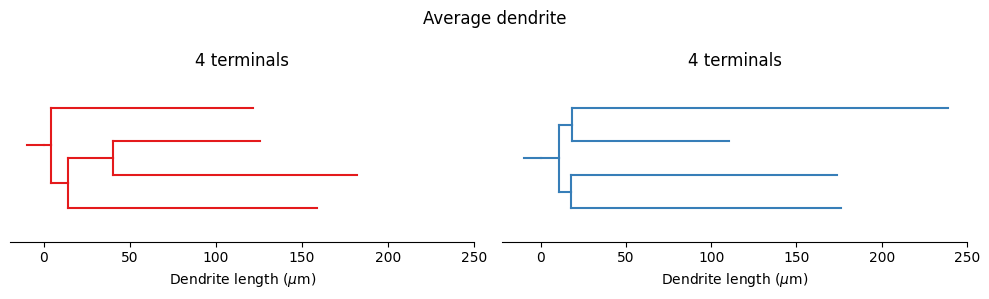

In [19]:
fig = plt.figure(figsize=(10,3))
fig.suptitle('Average dendrite')

ax = fig.add_subplot(1, 2, 1)
ax.set_title(f'{breadth:.0f} terminals')
plot_dgram(mg, ax, color=mcolor)
ax.set_yticks([])
ax.set_ylim(bottom=0, top=breadth+1)
ax.spines.left.set_visible(False)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_xlim(right=250)
ax.set_xlabel('Dendrite length ($\mu$m)');

ax = fig.add_subplot(1, 2, 2)
ax.set_title(f'{hg.xdata[0][BREADTH]:.0f} terminals')
plot_dgram(hg, ax, color=hcolor)
ax.set_yticks([])
ax.set_ylim(bottom=0, top=breadth+1)
ax.spines.left.set_visible(False)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_xlim(right=250)
ax.set_xlabel('Dendrite length ($\mu$m)')

fig.tight_layout()
fig.savefig('images/dend-branches-1.pdf')
mavg, havg

In [20]:
mmax = mbranches[-1]
hmax = hbranches[-1]

In [21]:
mg_max = DGram(mmax[2], types=[SWC.DEND])
mbreadth_max = mg_max.xdata[0][BREADTH]

In [22]:
hg_max = DGram(hmax[2], types=[SWC.DEND])
hbreadth_max = hg_max.xdata[0][BREADTH]

(array(['../data/mouse/derived/sanitized/animal_5_n27_04102017_cel1-cor-san.swc',
        457, <treem.morph.Morph object at 0x7f5a8910c5e0>, 13,
        1067.924523154747], dtype=object),
 array(['../data/human/derived/sanitized/AB6_porta32_cel2-cor-san.swc', 12,
        <treem.morph.Morph object at 0x7f5a881bf9d0>, 21,
        2044.244855881104], dtype=object))

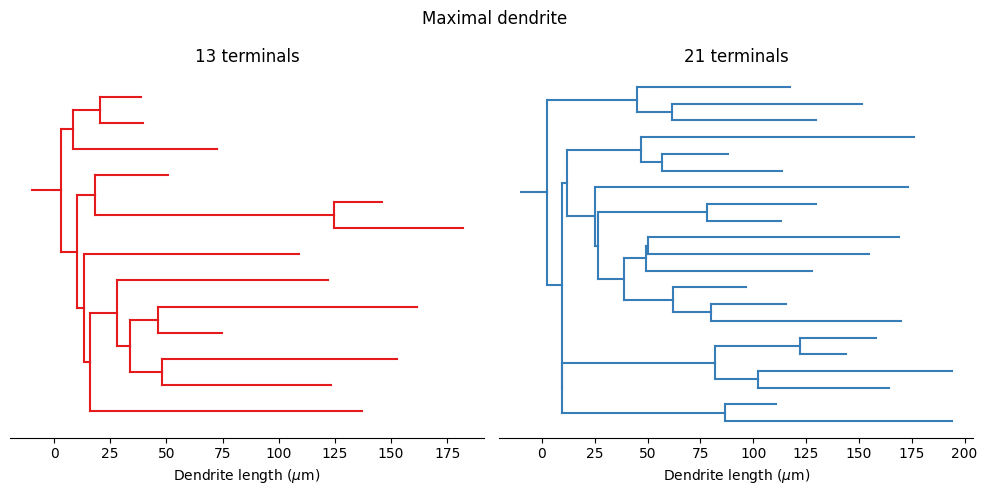

In [23]:
fig = plt.figure(figsize=(10,5))
fig.suptitle('Maximal dendrite')

ax = fig.add_subplot(1, 2, 1)
ax.set_title(f'{mbreadth_max:.0f} terminals')
plot_dgram(mg_max, ax, color=mcolor)
ax.set_yticks([])
ax.set_ylim(bottom=0, top=mbreadth_max+1)
ax.spines.left.set_visible(False)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_xlabel('Dendrite length ($\mu$m)');

ax = fig.add_subplot(1, 2, 2)
ax.set_title(f'{hbreadth_max:.0f} terminals')
plot_dgram(hg_max, ax, color=hcolor)
ax.set_yticks([])
ax.set_ylim(bottom=0, top=hbreadth_max+1)
ax.spines.left.set_visible(False)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_xlabel('Dendrite length ($\mu$m)')

fig.tight_layout()
fig.savefig('images/dend-branches-2.pdf')
mmax, hmax

In [24]:
mcells = list()

for src in glob('../data/mouse/derived/postproc/*.swc'):
    m = Morph(src)
    for stem in m.stems():
        if stem.type() == SWC.AXON:
            m.prune(stem)
    cell = Morph(data=m.data)
    breadth = cell.root.breadth()
    totlen = sum([x.length() for x in cell.root.walk() if x.type != SWC.SOMA])
    mcells.append([src, cell, breadth, totlen])

In [25]:
mcells = np.array(sorted(mcells, key=lambda x: (x[2], x[3])))

In [26]:
hcells = list()

for src in glob('../data/human/derived/postproc/*.swc'):
    m = Morph(src)
    for stem in m.stems():
        if stem.type() == SWC.AXON:
            m.prune(stem)
    cell = Morph(data=m.data)
    breadth = cell.root.breadth()
    totlen = sum([x.length() for x in cell.root.walk() if x.type != SWC.SOMA])
    hcells.append([src, cell, breadth, totlen])

In [27]:
hcells = np.array(sorted(hcells, key=lambda x: (x[2], x[3])))

In [28]:
mcell_breadth = np.mean(mcells[:,slice(2,3)])  #np.median(mcells[:,slice(2,3)])
hcell_breadth = np.mean(hcells[:,slice(2,3)])  #np.median(hcells[:,slice(2,3)])
mcell_breadth, hcell_breadth

(30.127659574468087, 33.22222222222222)

In [29]:
mcell_sel = mcells[:, 2] == np.rint(mcell_breadth)
hcell_sel = hcells[:, 2] == np.ceil(hcell_breadth)
mcell_avg = mcells[mcell_sel][-1]
hcell_avg = hcells[hcell_sel][-1]

In [30]:
mcell_g = DGram(mcell_avg[1], types=[SWC.DEND])

In [31]:
hcell_g = DGram(hcell_avg[1], types=[SWC.DEND])

(array(['../data/mouse/derived/postproc/animal_1_n33_04102017_cel1-cor-rep28-post.swc',
        <treem.morph.Morph object at 0x7f5a847e7d60>, 30,
        2893.2339757119767], dtype=object),
 array(['../data/human/derived/postproc/AB5_porta79_cel1-cor-rep69-post.swc',
        <treem.morph.Morph object at 0x7f5a8367f520>, 34, 5933.94381672072],
       dtype=object))

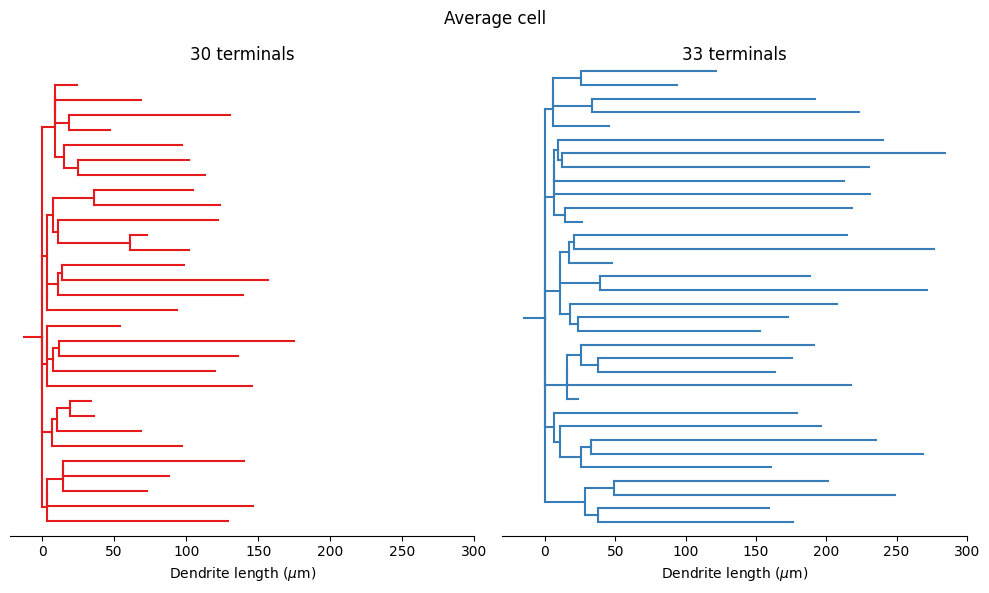

In [32]:
fig = plt.figure(figsize=(10,6))
fig.suptitle('Average cell')

ax = fig.add_subplot(1, 2, 1)
ax.set_title(f'{mcell_breadth:.0f} terminals')
plot_dgram(mcell_g, ax, color=mcolor)
ax.set_yticks([])
ax.set_ylim(bottom=0, top=mcell_breadth+1)
ax.spines.left.set_visible(False)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_xlim(right=300)
ax.set_xlabel('Dendrite length ($\mu$m)');

ax = fig.add_subplot(1, 2, 2)
ax.set_title(f'{hcell_breadth:.0f} terminals')
plot_dgram(hcell_g, ax, color=hcolor)
ax.set_yticks([])
ax.set_ylim(bottom=0, top=hcell_breadth+1)
ax.spines.left.set_visible(False)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_xlim(right=300)
ax.set_xlabel('Dendrite length ($\mu$m)')

fig.tight_layout()
fig.savefig('images/dend-branches-3.pdf')
mcell_avg, hcell_avg

In [33]:
mcell_max = mcells[-1]
hcell_max = hcells[-1]

In [34]:
mcell_g_max = DGram(mcell_max[1], types=[SWC.DEND])
mcell_breadth_max = mcell_g_max.xdata[0][BREADTH]

In [35]:
hcell_g_max = DGram(hcell_max[1], types=[SWC.DEND])
hcell_breadth_max = hcell_g_max.xdata[0][BREADTH]

In [36]:
mcell_breadth_max, hcell_breadth_max

(46.0, 45.0)

(array(['../data/mouse/derived/postproc/animal_1_n30_04102017_cel2-cor-rep28-post2.swc',
        <treem.morph.Morph object at 0x7f5a854d7f40>, 46,
        3737.8614549463973], dtype=object),
 array(['../data/human/derived/postproc/AB5_porta80A_cel13-cor-rep42-post2.swc',
        <treem.morph.Morph object at 0x7f5a836421a0>, 45,
        7260.746196549739], dtype=object))

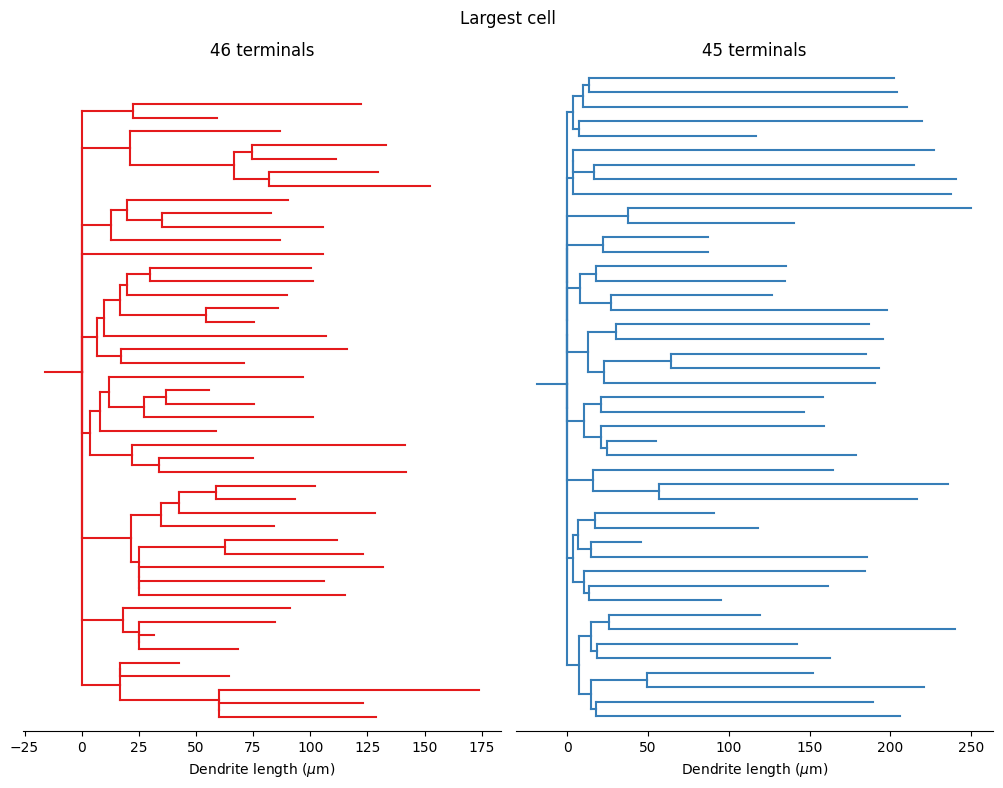

In [37]:
fig = plt.figure(figsize=(10,8))
fig.suptitle('Largest cell')

ax = fig.add_subplot(1, 2, 1)
ax.set_title(f'{mcell_breadth_max:.0f} terminals')
plot_dgram(mcell_g_max, ax, color=mcolor)
ax.set_yticks([])
ax.set_ylim(bottom=0, top=mcell_breadth_max+3)
ax.spines.left.set_visible(False)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_xlabel('Dendrite length ($\mu$m)');

ax = fig.add_subplot(1, 2, 2)
ax.set_title(f'{hcell_breadth_max:.0f} terminals')
plot_dgram(hcell_g_max, ax, color=hcolor)
ax.set_yticks([])
ax.set_ylim(bottom=0, top=hcell_breadth_max+1)
ax.spines.left.set_visible(False)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_xlabel('Dendrite length ($\mu$m)')

fig.tight_layout()
fig.savefig('images/dend-branches-4.pdf')
mcell_max, hcell_max

breadth=1 len(mbranches[msel])=8 len(hbranches[hsel])=4
breadth=2 len(mbranches[msel])=4 len(hbranches[hsel])=4
breadth=3 len(mbranches[msel])=6 len(hbranches[hsel])=9
breadth=4 len(mbranches[msel])=9 len(hbranches[hsel])=6


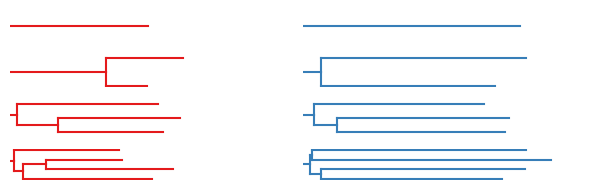

In [38]:
fig = plt.figure(figsize=(6, 2))

for i, breadth in enumerate([1, 2, 3, 4]):
    msel = mbranches[:, 3] == breadth
    hsel = hbranches[:, 3] == breadth
    print(f'{breadth=} {len(mbranches[msel])=} {len(hbranches[hsel])=}')
    
    ax = fig.add_subplot(4, 2, 2*i+1)
    mdend = mbranches[msel][-1]
    mg = DGram(mdend[2], types=[SWC.DEND])
    plot_dgram(mg, ax, color=mcolor, plot_soma=False)
    ax.set_xlim(0, 310)
    ax.set_axis_off()
    
    ax = fig.add_subplot(4, 2, 2*i+2)
    hdend = hbranches[hsel][-1]
    hg = DGram(hdend[2], types=[SWC.DEND])
    plot_dgram(hg, ax, color=hcolor, plot_soma=False)
    ax.set_xlim(0, 310)
    ax.set_axis_off()

fig.tight_layout()
fig.savefig('images/dend-branches-5.pdf')

breadth=5 len(mbranches[msel])=6 len(hbranches[hsel])=2
breadth=6 len(mbranches[msel])=4 len(hbranches[hsel])=5
breadth=7 len(mbranches[msel])=4 len(hbranches[hsel])=1
breadth=8 len(mbranches[msel])=4 len(hbranches[hsel])=2


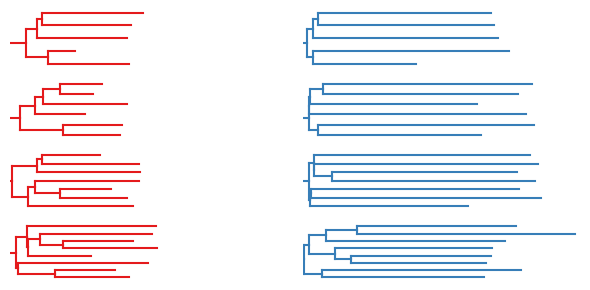

In [39]:
fig = plt.figure(figsize=(6, 3))

for i, breadth in enumerate([5, 6, 7, 8]):
    msel = mbranches[:, 3] == breadth
    hsel = hbranches[:, 3] == breadth
    print(f'{breadth=} {len(mbranches[msel])=} {len(hbranches[hsel])=}')
    
    ax = fig.add_subplot(4, 2, 2*i+1)
    if msel.any():
        mdend = mbranches[msel][-1]
        mg = DGram(mdend[2], types=[SWC.DEND])
        plot_dgram(mg, ax, color=mcolor, plot_soma=False)
    ax.set_xlim(0, 310)
    ax.set_axis_off()
    
    ax = fig.add_subplot(4, 2, 2*i+2)
    hdend = hbranches[hsel][-1]
    hg = DGram(hdend[2], types=[SWC.DEND])
    plot_dgram(hg, ax, color=hcolor, plot_soma=False)
    ax.set_xlim(0, 310)
    ax.set_axis_off()

fig.tight_layout()
fig.savefig('images/dend-branches-6.pdf')

mbreadth=13 hbreadth=15 len(mbranches[msel])=1 len(hbranches[hsel])=1
hbreadth=21 len(hbranches[hsel])=1


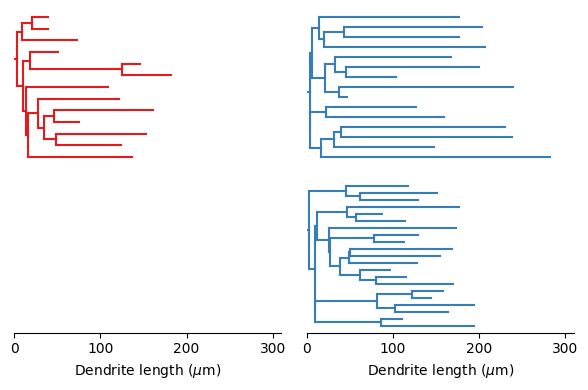

In [40]:
fig = plt.figure(figsize=(6, 4))

if True:
    mbreadth = 13
    hbreadth = 15
    msel = mbranches[:, 3] == mbreadth
    hsel = hbranches[:, 3] == hbreadth
    print(f'{mbreadth=} {hbreadth=} {len(mbranches[msel])=} {len(hbranches[hsel])=}')
    
    ax = fig.add_subplot(2, 2, 1)
    mdend = mbranches[msel][-1]
    mg = DGram(mdend[2], types=[SWC.DEND])
    plot_dgram(mg, ax, color=mcolor, plot_soma=False)
    ax.set_xlim(0, 310)
    ax.set_axis_off()
    
    ax = fig.add_subplot(2, 2, 2)
    hdend = hbranches[hsel][-1]
    hg = DGram(hdend[2], types=[SWC.DEND])
    plot_dgram(hg, ax, color=hcolor, plot_soma=False)
    ax.set_xlim(0, 310)
    ax.set_axis_off()

if True:
    hbreadth = 21
    hsel = hbranches[:, 3] == hbreadth
    print(f'{hbreadth=} {len(hbranches[hsel])=}')
    
    ax = fig.add_subplot(2, 2, 3)
    ax.set_xlim(0, 310)
    ax.set_yticks([])
    ax.spines.left.set_visible(False)
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.set_xlabel('Dendrite length ($\mu$m)')
    
    ax = fig.add_subplot(2, 2, 4)
    hdend = hbranches[hsel][-1]
    hg = DGram(hdend[2], types=[SWC.DEND])
    plot_dgram(hg, ax, color=hcolor, plot_soma=False)
    ax.set_xlim(0, 310)
    ax.set_yticks([])
    ax.spines.left.set_visible(False)
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.set_xlabel('Dendrite length ($\mu$m)')

fig.tight_layout()
fig.savefig('images/dend-branches-7.pdf')